In [1]:
import numpy as np
import matplotlib.pyplot as plt

from squlearn import Executor
from squlearn.encoding_circuit import ChebyshevRx
from squlearn.observables import SummedPaulis
from squlearn.qnn import QNNRegressor, SquaredLoss
from squlearn.optimizers import Adam, SGLBO

from skopt import gp_minimize, expected_minimum


#from sklearn.gaussian_process import GaussianProcessRegressor
#from sklearn.gaussian_process.kernels import Matern, WhiteKernel, RBF

from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import Matern, WhiteKernel, RBF

## PQC

C:\Users\DKR\AppData\Roaming\Python\Python310\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


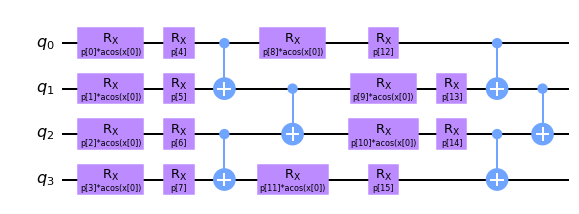

In [2]:
num_shots = 50

executor = Executor("qasm_simulator")
executor.set_shots(num_shots)

nqubits = 4
number_of_layers = 2

pqc = ChebyshevRx(nqubits, 1, num_layers=number_of_layers)
pqc.draw("mpl")

## Observable

In [3]:
op = SummedPaulis(nqubits)
print(op)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[3]),
 ParameterExpression(1.0*p[4])])


In [4]:
def sigmoid(x, a, b, c):
    return 1 / (1 + np.exp(-a * (x - b) / c))

In [5]:
# Randomly initialize parameters of the encoding circuit
np.random.seed(13)
param_ini =  np.random.rand(pqc.num_parameters)
# Initialize parameters of the observable as ones
param_op_ini = np.random.rand(op.num_parameters)

x_train = np.arange(-1, 1.1, 0.1)
y_train = sigmoid(x_train, 5, 0, 1)



In [6]:
x0 = [[1e-6], [5e-6], [1e-5], [5e-5]]
optimizer_options = {"bo_aqc_func": "EI", "bo_aqc_optimizer": "lbfgs", "bo_bounds": [(0.0, 0.2)], "log_file": "sglbo_sigmoid_noise_new.log",
                     "bo_n_calls": 60, "bo_x0_points": x0, "maxiter": 300}

qnn_noisy = QNNRegressor(
    pqc,
    op,
    executor,
    SquaredLoss(),
    SGLBO(optimizer_options),
    param_ini,
    param_op_ini=param_op_ini,
)

qnn_noisefree = QNNRegressor(
    pqc,
    op,
    Executor("statevector_simulator"),
    SquaredLoss(),
    SGLBO(optimizer_options),
    param_ini,
    param_op_ini=param_op_ini,
)

In [7]:
def evaluate_loss(theta, qnn_regressor: QNNRegressor, X, y):
    param = theta[: qnn_regressor._qnn.num_parameters]
    param_op = theta[qnn_regressor._qnn.num_parameters :]

    loss_values = qnn_regressor._qnn.evaluate(qnn_regressor.loss.loss_args_tuple, X, param, param_op)

    loss_value = qnn_regressor.loss.value(
        loss_values,
        ground_truth=y,
        weights=np.ones(len(y)),
        iteration=0,
    )

    return loss_value


def evaluate_loss_variance(theta, qnn_regressor: QNNRegressor, X, y):
    param = theta[: qnn_regressor._qnn.num_parameters]
    param_op = theta[qnn_regressor._qnn.num_parameters :]

    loss_values = qnn_regressor._qnn.evaluate(qnn_regressor.loss.variance_args_tuple, X, param, param_op)

    loss_value = qnn_regressor.loss.variance(
        loss_values,
        ground_truth=y,
        weights=np.ones(len(y)),
        iteration=0,
    )

    return loss_value


In [8]:
param = np.array([ 0.90188812,  0.24107649,  0.77594797,  1.42321801,  1.1142016 ,  0.44067169,
  0.52859497,  0.92242668,  0.01521759,  0.69437114,  0.13113242,  0.76001705,
 -0.16016357,  0.81846978,  0.4212208 ,  0.82229221,  0.79631544,  0.32070702,
  0.10292222,  0.42838383,  0.97817512])


grad = np.array([ 2.38344023, -3.14310031,  0.51410924,  1.99572056,  0.96659542, -1.49326947,
  0.33410333,  1.15420496,  0.28851028,  0.92035961, -1.49312591,  1.97126941,
  0.13215843,  0.55944491, -0.76135106,  1.18595071, -4.06515594,  2.88410852,
  0.43698936,  0.01215489,  0.93930853])



evaluate_loss_variance(param, qnn_noisefree, x_train, y_train)

2.390263245750887

In [9]:
def loss_noisy(x):
    return evaluate_loss(x,qnn_noisy,x_train,y_train)

def loss_noisefree(x):
    return evaluate_loss(x,qnn_noisefree,x_train,y_train)


In [10]:
bo_bounds = [(0.0, 0.2)]
bo_n_calls = 60
bo_aqc_func = "EI"
bo_aqc_optimizer = "lbfgs"
bo_x0_points = x0
bo_noise = "gaussian"  #  evaluate_loss_variance(param, qnn_noisefree, x_train, y_train)/num_shots

In [11]:
  # cost function to optimize the step size in one dimension
x_list = []
y_list = []


def step_size_cost(x):
    fval = loss_noisy(param-x*grad)
    x_list.append(x)
    y_list.append(fval)
    # print("BOP ", "fval: ", fval, " x: ", x)
    return fval

def step_size_cost_ref(x):
    fval = loss_noisefree(param-x*grad)
    x_list.append(x)
    y_list.append(fval)
    # print("BOP ", "fval: ", fval, " x: ", x)
    return fval


def step_size_cost_print(x):
    fval = loss_noisy(param-x*grad)
    x_list.append(x)
    y_list.append(fval)
    print("BOP ", "fval: ", fval, " x: ", x)
    return fval

# bayesian optimization to estimate the step size in one dimension
res = gp_minimize(    step_size_cost_print, bo_bounds, n_calls=bo_n_calls, acq_func=bo_aqc_func,
                        acq_optimizer=bo_aqc_optimizer, x0=bo_x0_points, n_jobs=-1, random_state=10, noise=bo_noise, n_initial_points=0)
x_val, fun = expected_minimum(res)
x_val = res.x
fun = res.fun

BOP  fval:  1.3695226358016326  x:  [1e-06]
BOP  fval:  0.791324083282171  x:  [5e-06]
BOP  fval:  1.1464433971504193  x:  [1e-05]
BOP  fval:  1.0313972938663312  x:  [5e-05]
BOP  fval:  14.28823991511575  x:  [0.10102611574991167]
BOP  fval:  1.1313818449788318  x:  [0.02641081967082526]
BOP  fval:  32.61454953308778  x:  [0.2]
BOP  fval:  0.688605469769243  x:  [0.01369172984904983]
BOP  fval:  0.6855277437378542  x:  [0.013747922170107283]
BOP  fval:  0.5152283903909545  x:  [0.013620838217670303]
BOP  fval:  1.2402441980807852  x:  [0.013683283316438533]
BOP  fval:  0.7647634339969304  x:  [0.015200511485083277]
BOP  fval:  0.7283207584354476  x:  [0.014701117164641784]
BOP  fval:  1.9517104080997136  x:  [0.029084431138806197]
BOP  fval:  1.071794737248211  x:  [0.01086726385263005]
BOP  fval:  0.5732046514034337  x:  [0.010860801349413833]
BOP  fval:  0.699520143044352  x:  [0.010869624752745603]
BOP  fval:  0.7132406218432998  x:  [0.010870737343835594]
BOP  fval:  0.99613257461

In [12]:
print("Final step size:",res.x)
print("Final value",res.fun)

Final step size: [0.018622906318692258]
Final value 0.451239991192954


<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

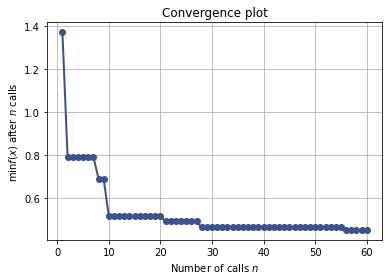

In [13]:
from skopt.plots import plot_convergence

plot_convergence(res)

<AxesSubplot:title={'center':'x* = 0.0186, f(x*) = 0.4512'}, xlabel='x', ylabel='f(x)'>

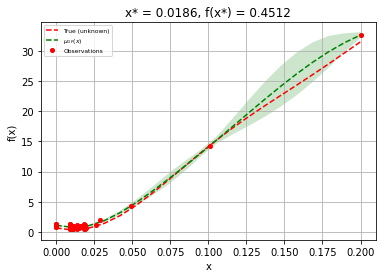

In [14]:
from skopt.plots import plot_gaussian_process

plot_gaussian_process(res, n_calls=len(res.models)-1, objective=step_size_cost_ref, n_points=20)

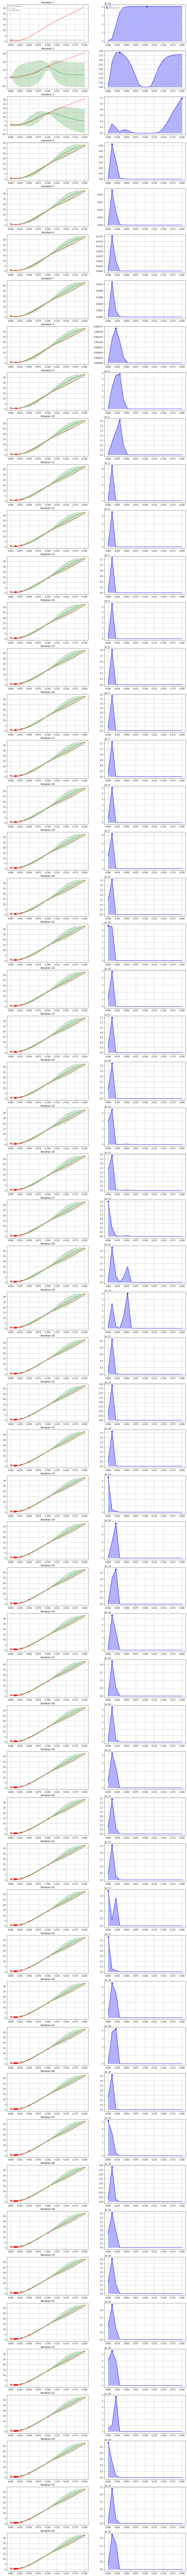

In [15]:
#plt.rcParams["figure.figsize"] = (16, 160)

plt.figure(figsize=(16, 240))


for n_iter in range(len(res.models)-1):
    # Plot true function.
    plt.subplot(len(res.models), 2, 2*n_iter+1)

    if n_iter == 0:
        show_legend = True
    else:
        show_legend = False

    ax = plot_gaussian_process(res, n_calls=n_iter,n_points=20,
                               objective=step_size_cost_ref,
                               noise_level=0.1,
                               show_legend=show_legend, show_title=False,
                               show_next_point=True, show_acq_func=False)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_title("Iteration %d" % (n_iter + 1))
    # Plot EI(x)
    plt.subplot(len(res.models), 2, 2*n_iter+2)
    ax = plot_gaussian_process(res, n_calls=n_iter,n_points=20,
                               show_legend=show_legend, show_title=False,
                               show_mu=False, show_acq_func=True,
                               show_observations=False,
                               show_next_point=True)
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.show()

In [16]:
res.x_iters

[[1e-06],
 [5e-06],
 [1e-05],
 [5e-05],
 [0.10102611574991167],
 [0.02641081967082526],
 [0.2],
 [0.01369172984904983],
 [0.013747922170107283],
 [0.013620838217670303],
 [0.013683283316438533],
 [0.015200511485083277],
 [0.014701117164641784],
 [0.029084431138806197],
 [0.01086726385263005],
 [0.010860801349413833],
 [0.010869624752745603],
 [0.010870737343835594],
 [0.010850420403985787],
 [0.010871275183852273],
 [0.01081554442507238],
 [0.010810906046197258],
 [0.010779541966522935],
 [0.010706170654256233],
 [3.0902778205943455e-06],
 [0.0102233171378503],
 [0.010161870419864452],
 [0.01001259246390354],
 [0.009553356291309649],
 [0.009327171372494638],
 [2.7551824919958007e-05],
 [0.015818859046689074],
 [0.049074732801207034],
 [0.015056755600600739],
 [0.009398519732747083],
 [0.009363995293025874],
 [3.996073986995975e-05],
 [0.016848248341236396],
 [0.016888059530330637],
 [0.01694062975222293],
 [0.016979672427447894],
 [0.009693341355267452],
 [0.01778071011996614],
 [0.009

TypeError: 'float' object is not subscriptable

In [32]:
def fun_min(x):
    fval = res.models[-1].predict(res.space.transform(np.array([x])))[0]
    print(x, fval)
    return fval

from scipy.optimize import minimize

res2 = minimize(fun_min, x0=res.x[0], method='Nelder-Mead', tol=1e-6)

print(res2.x)
print(res.x)

[0.01862291] 0.9063316255456532
[0.01955405] 0.9451870194082472
[0.01769176] 0.8724748690334208
[0.01676062] 0.84361958454956
[0.01489833] 0.800852465978337
[0.01303603] 0.7777712577221063
[0.00931145] 0.7885873423744643
[0.01117374] 0.7739056027962795
[0.00931145] 0.7885873423744643
[0.01210489] 0.7734738143019656
[0.01303603] 0.7777712577221063
[0.01163932] 0.7731038833304946
[0.01117374] 0.7739056027942768
[0.0118721] 0.7731416977400588
[0.01140653] 0.7733589927945973
[0.01175571] 0.7730860878466039
[0.0118721] 0.7731416977400588
[0.01169751] 0.7730858207075239
[0.01163932] 0.7731038833324974
[0.01172661] 0.7730836616986676
[0.01175571] 0.7730860878461032
[0.01171206] 0.7730841682296058
[0.01174116] 0.7730843014619344
[0.01171934] 0.7730837717009559
[0.01173389] 0.7730838382713076
[0.01172297] 0.773083680882671
[0.01173025] 0.7730837141622141
[0.01172479] 0.7730836623350386
[0.01172843] 0.7730836789818196
[0.0117257] 0.7730836597765373
[0.0117257]
[0.018622906318692258]


[0.] 1.1081078438021503
[0.0020202] 1.0074215339245394
[0.0040404] 0.9229796193330432
[0.00606061] 0.8560931555757261
[0.00808081] 0.8080641960021333
[0.01010101] 0.7801483844553454
[0.01212121] 0.7735081789174825
[0.01414141] 0.7891186900721655
[0.01616162] 0.827695872682833
[0.01818182] 0.8896698913670216
[0.02020202] 0.975166616401854
[0.02222222] 1.0839911324176668
[0.02424242] 1.2156424301744742
[0.02626263] 1.3693518830706148
[0.02828283] 1.5441252075944298
[0.03030303] 1.7388030832359334
[0.03232323] 1.9521659660084913
[0.03434343] 2.182999313889412
[0.03636364] 2.430106361916934
[0.03838384] 2.692314952027614
[0.04040404] 2.968484378221696
[0.04242424] 3.257512271328168
[0.04444444] 3.5583415364444093
[0.04646465] 3.86996735634436
[0.04848485] 4.191444274036262
[0.05050505] 4.521893350338808
[0.05252525] 4.860508097499308
[0.05454545] 5.206554498243755
[0.05656566] 5.5593670268676885
[0.05858586] 5.918344428217721
[0.06060606] 6.282945601823471
[0.06262626] 6.65268558506552
[0.

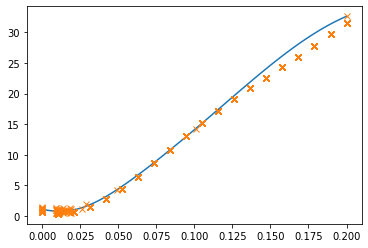

In [35]:
xx = np.linspace(0, 0.2, 100).reshape(-1, 1)
plt.figure()


plt.plot(xx, [fun_min(x) for x in xx])
plt.plot(res.models[-1].X_train_, res.models[-1].y_train_, 'x')

#     ,
#     